# ===== Resultados do GridSearch (melhor combinação) =====
Melhores parâmetros: {'clf__ccp_alpha': 0.0, 'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 2, 'pca__n_components': None}
ROC AUC (CV treino) do melhor: 0.8221

# ===== Pruning =====
Melhor ccp_alpha encontrado: 0.0

# ===== Validação Cruzada (treino) com melhor modelo =====
ROC AUC (média ± desvio): 0.8221 ± 0.0594

# ===== Métricas no Teste =====
Acurácia         : 0.6667
Precisão         : 0.6176
Recall/Sensib.   : 0.7241
Especificidade   : 0.6176
F1-Score         : 0.6667
ROC AUC          : 0.6917

Matriz de Confusão (Teste):
 [[21 13]
 [ 8 21]]

Relatório de Classificação (Teste):

              precision    recall  f1-score   support

    R (rock)       0.72      0.62      0.67        34
    M (mine)       0.62      0.72      0.67        29

    accuracy                           0.67        63
   macro avg       0.67      0.67      0.67        63
weighted avg   

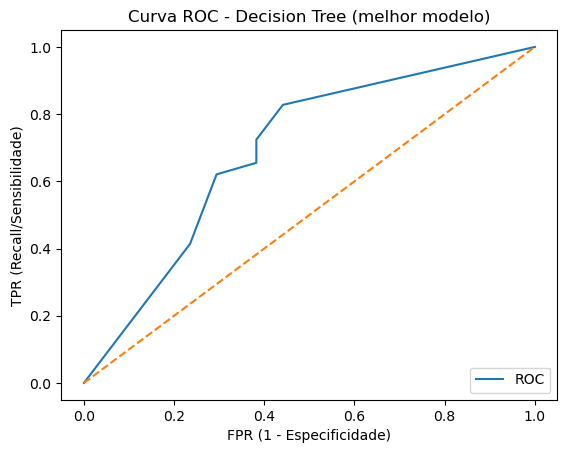


# ===== PCA =====
Componentes usados: 60
Variância explicada acumulada: 1.0


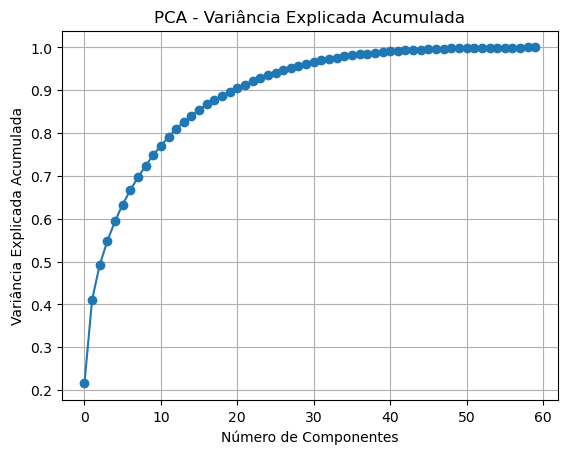


# ===== Interpretação =====
- A separação entre classes é limitada (AUC < 0.70).
- Sensibilidade e especificidade são medianas; pode haver espaço para calibrar o limiar de decisão.
- Há indício de leve sobreajuste (desempenho em CV consideravelmente maior que no teste).
- A busca escolheu manter todas as componentes no PCA (sem redução efetiva), sugerindo que a redução não ajudou.


In [2]:
# -------- [Imports] --------
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------- [Leitura do Dataset] --------
candidates = [
    "sonar_dataset.csv"
]

path = None
for c in candidates:
    if os.path.exists(c):
        path = c
        break

if path is None:
    raise FileNotFoundError("Não foi possível localizar 'sonar_dataset.csv'. Coloque o arquivo ao lado do notebook ou ajuste o caminho no código.")

try:
    df = pd.read_csv(path)
    if not df.iloc[:, -1].astype(str).str.match(r'^[MR]$').all():
        df = pd.read_csv(path, header=None)
except Exception:
    df = pd.read_csv(path, header=None)

if not df.iloc[:, -1].astype(str).str.match(r'^[MR]$').all():
    df = pd.read_csv(path, header=None)

X = df.iloc[:, :-1].astype(float).values
y_raw = df.iloc[:, -1].astype(str).values

# Converte rótulos: M (mine) como classe positiva = 1; R (rock) = 0
le = LabelEncoder()
le.fit(["R", "M"])
y = le.transform(y_raw)  # R->0, M->1

# -------- [Split] --------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

# ======================================================
# Questão 1 - Criação das features com PCA (Pipeline)
# ======================================================
# A Árvore de Decisão não exige padronização, mas o PCA sim.
# Por isso, usamos StandardScaler -> PCA -> DecisionTree
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=None, random_state=RANDOM_STATE)),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# ======================================================
# Questões 2, 3 e 4 - Modelo, Validação Cruzada e GridSearch
# ======================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Grade de hiperparâmetros, incluindo pruning via ccp_alpha
param_grid = {
    "pca__n_components": [5, 10, 15, 20, 30, None],
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [None, 3, 5, 7, 10],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4, 8],
    "clf__ccp_alpha": [0.0, 0.0005, 0.001, 0.005, 0.01]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid.fit(X_train, y_train)

print("# ===== Resultados do GridSearch (melhor combinação) =====")
print("Melhores parâmetros:", grid.best_params_)
print("ROC AUC (CV treino) do melhor:", round(grid.best_score_, 4))

# ======================================================
# Questão 5 - Pruning explícito via ccp_alpha (já otimizado na grade)
# ======================================================
best_alpha = grid.best_params_.get("clf__ccp_alpha", None)
print("\n# ===== Pruning =====")
print("Melhor ccp_alpha encontrado:", best_alpha)

# ======================================================
# Questão 3 (continuação) - Validação cruzada com o melhor modelo
# ======================================================
best_model = grid.best_estimator_
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
print("\n# ===== Validação Cruzada (treino) com melhor modelo =====")
print("ROC AUC (média ± desvio):", f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ======================================================
# Questão 6 - Avaliação no conjunto de teste
# ======================================================
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else float("nan")

print("\n# ===== Métricas no Teste =====")
print("Acurácia         :", round(acc, 4))
print("Precisão         :", round(prec, 4))
print("Recall/Sensib.   :", round(rec, 4))
print("Especificidade   :", round(specificity, 4))
print("F1-Score         :", round(f1, 4))
print("ROC AUC          :", round(auc, 4))
print("\nMatriz de Confusão (Teste):\n", cm)
print("\nRelatório de Classificação (Teste):\n")
print(classification_report(y_test, y_pred, target_names=["R (rock)", "M (mine)"], zero_division=0))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR (1 - Especificidade)")
plt.ylabel("TPR (Recall/Sensibilidade)")
plt.title("Curva ROC - Decision Tree (melhor modelo)")
plt.legend(loc="lower right")
plt.show()

# ======================================================
# Questão 1 (detalhe) - Variância explicada se PCA ativo
# ======================================================
best_pca = best_model.named_steps.get("pca", None)
if best_pca is not None and getattr(best_pca, "n_components_", None) is not None:
    n_comp = best_pca.n_components_
    exp_var = getattr(best_pca, "explained_variance_ratio_", None)
    if exp_var is not None:
        print("\n# ===== PCA =====")
        print("Componentes usados:", n_comp)
        print("Variância explicada acumulada:", round(np.sum(exp_var), 4))

        plt.figure()
        plt.plot(np.cumsum(exp_var), marker="o")
        plt.xlabel("Número de Componentes")
        plt.ylabel("Variância Explicada Acumulada")
        plt.title("PCA - Variância Explicada Acumulada")
        plt.grid(True)
        plt.show()

# ======================================================
# Questão 7 - Interpretação automática baseada nas métricas
# ======================================================
print("\n# ===== Interpretação =====")
interp = []

# Qualidade geral pelo AUC
if auc >= 0.9:
    interp.append("O classificador apresenta excelente separação entre classes (AUC ≥ 0.90).")
elif auc >= 0.8:
    interp.append("O classificador apresenta boa separação entre classes (0.80 ≤ AUC < 0.90).")
elif auc >= 0.7:
    interp.append("A separação entre classes é moderada (0.70 ≤ AUC < 0.80).")
else:
    interp.append("A separação entre classes é limitada (AUC < 0.70).")

# Trade-off sensibilidade x especificidade
if rec >= 0.85 and specificity >= 0.85:
    interp.append("O modelo equilibra bem sensibilidade e especificidade (ambas altas).")
elif rec >= 0.85:
    interp.append("O modelo prioriza sensibilidade (detecta minas), com possível aumento de falsos positivos.")
elif specificity >= 0.85:
    interp.append("O modelo prioriza especificidade (evita alarmes falsos), com risco de perder algumas minas (falsos negativos).")
else:
    interp.append("Sensibilidade e especificidade são medianas; pode haver espaço para calibrar o limiar de decisão.")

# Sobrefitting (indício simples comparando CV x Teste)
cv_mean = cv_scores.mean()
if (cv_mean - auc) > 0.05:
    interp.append("Há indício de leve sobreajuste (desempenho em CV consideravelmente maior que no teste).")
elif (auc - cv_mean) > 0.05:
    interp.append("O desempenho em teste superou a média de CV; possivelmente divisão de dados favoreceu o teste.")
else:
    interp.append("Desempenho de teste consistente com a média de CV, indicando boa generalização.")

# PCA utilidade
if best_pca is not None:
    if best_model.get_params().get("pca__n_components") is None:
        interp.append("A busca escolheu manter todas as componentes no PCA (sem redução efetiva), sugerindo que a redução não ajudou.")
    else:
        interp.append("A busca escolheu reduzir dimensionalidade via PCA, indicando ganho potencial de generalização/ruído reduzido.")

for line in interp:
    print("-", line)
